In [18]:
# merge_all.csv 파일을 사용하여 "가격 (원)" 컬럼의 값을 예측하는 모델을 만든다

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
import keras




In [19]:
# 데이터 불러오기
df = pd.read_csv('data/merge_all/merge_all.csv')

# 데이터 전처리
# "거래년월일" 컬럼을 인덱스로 설정
df = df.set_index('거래년월일')
# "평균" 컬럼을 배추가격으로 설정
df = df.rename(columns={'평균':'배추가격'})
df.head()

,자동차용 경유 가격 (원),전월비(%),배추가격,거래량
거래년월일,,,,
2000-01-01,583.35,4.0,5600.0,102285.0
2000-01-02,583.35,4.0,5600.0,102285.0
2000-01-03,583.35,4.0,5600.0,102285.0
2000-01-04,583.35,4.0,5600.0,715338.0
2000-01-05,583.35,4.0,5620.0,340568.0


In [20]:
# df 를 시퀀스 데이터로 변환
# 1. 데이터를 7일 단위로 묶는다

# 7일 단위로 묶는 함수
def make_sequence_data(data, window_size):
    x, y = [], []
    for i in range(len(data) - window_size):
        group = data.iloc[i:(i+window_size)]
        x.append(group.values)
        y.append(data.iloc[i+window_size][0])
    return np.array(x), np.array(y)

# 7일 단위로 묶는다
window_size = 7
x, y = make_sequence_data(df, window_size)
print(x.shape, y.shape)

# 2. 데이터를 학습용 데이터와 테스트용 데이터로 나눈다
# 학습용 데이터와 테스트용 데이터를 7:3으로 나눈다
train_size = int(len(y) * 0.7)
test_size = len(y) - train_size
train_x, test_x = np.array(x[0:train_size]), np.array(x[train_size:len(x)])
train_y, test_y = np.array(y[0:train_size]), np.array(y[train_size:len(y)])
print(train_x.shape, test_x.shape)

# 3. 데이터를 정규화한다
# 정규화 함수 dim=3
def normalize(data):
    norm_data = np.zeros(data.shape)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            norm_data[i, j] = (data[i, j] - np.min(data[i, j])) / (np.max(data[i, j]) - np.min(data[i, j]))
    return norm_data

# 정규화
train_x = normalize(train_x)
test_x = normalize(test_x)
train_x.shape, test_x.shape






(8363, 7, 4) (8363,)
(5854, 7, 4) (2509, 7, 4)


((5854, 7, 4), (2509, 7, 4))

In [26]:
# 모델을 생성한다 shape=(None, 7, 4) return_sequences=True
model = Sequential()
model.add(LSTM(128, input_shape=(7,4), return_sequences=True))
#convolutional layer
model.add(keras.layers.Conv1D(64, 3, activation='relu'))
model.add(keras.layers.MaxPooling1D(2))
model.add(keras.layers.Flatten())
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 7, 128)            68096     
                                                                 
 conv1d_7 (Conv1D)           (None, 5, 64)             24640     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 92,865
Trainable params: 92,865
Non-trainable params: 0
__________________________________________________

In [29]:
# 모델을 학습
model.fit(train_x, train_y, epochs=10000, batch_size=1000, verbose=1)

# 저장
model.save('model/predict_price.h5')

Epoch 1/10000
37/37 [==============================] - 1s 15ms/step - loss: 169391.8906 - val_loss: 194495.3906
Epoch 2/10000
37/37 [==============================] - 1s 15ms/step - loss: 169356.5156 - val_loss: 197747.9531
Epoch 3/10000
37/37 [==============================] - 0s 13ms/step - loss: 169375.7500 - val_loss: 196640.7500
Epoch 4/10000
37/37 [==============================] - 0s 13ms/step - loss: 169309.0156 - val_loss: 188520.0625
Epoch 5/10000
37/37 [==============================] - 0s 13ms/step - loss: 169353.1406 - val_loss: 197631.2500
Epoch 6/10000
37/37 [==============================] - 0s 13ms/step - loss: 169247.9375 - val_loss: 193379.7656
Epoch 7/10000
37/37 [==============================] - 1s 15ms/step - loss: 169228.5625 - val_loss: 195779.2969
Epoch 8/10000
37/37 [==============================] - 1s 14ms/step - loss: 169237.2812 - val_loss: 197459.9219
Epoch 9/10000
37/37 [==============================] - 1s 14ms/step - loss: 169249.8281 - val_loss: 1966

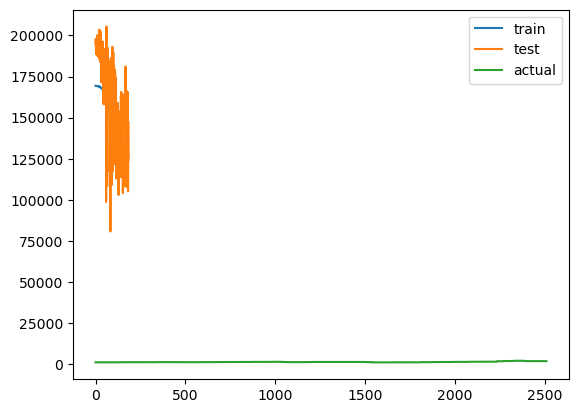

In [30]:
#  학습 결과를 그래프로 그린다
plt.plot(model.history.history['loss'])
plt.show()

# 실제값
plt.plot(test_y, label='actual')
plt.legend()
plt.show()



In [31]:
#  모델을 평가한다
#  RMSE
train_predict = model.predict(train_x)
test_predict = model.predict(test_x)
train_score = np.sqrt(mean_squared_error(train_y, train_predict))
test_score = np.sqrt(mean_squared_error(test_y, test_predict))
print('Train Score: %.2f RMSE' % (train_score))
print('Test Score: %.2f RMSE' % (test_score))



  6/183 [..............................] - ETA: 1s 

2022-12-22 16:01:35.530973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-22 16:01:35.577096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 0s 6ms/step
Train Score: 354.87 RMSE
Test Score: 305.36 RMSE


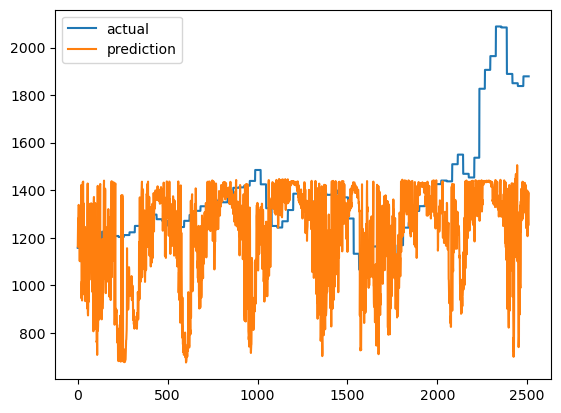

In [32]:
#  예측 결과를 그래프로 그린다
plt.plot(test_y, label='actual')
plt.plot(test_predict, label='prediction')
plt.legend()
plt.show()
